In [11]:
%pylab inline
import pydot
from IPython.display import Image, display, SVG
import re

Populating the interactive namespace from numpy and matplotlib


A neural network, or "multilayer perceptron", is made up of units computing a nonlinear transformation of a weighted sum of their inputs. So the output of a unit looks something like:

\begin{equation}
o(x_1,x_2,...x_n) = \sigma(w_0 + w_1 x_1 + w_2 x_2 + ... w_n x_n)
\end{equation}

$w_0$ represents a bias that does not depend on the input.

Here the nonlinear function $\sigma$ is the logistic sigmoid function, which as we shall see, is useful because it is a continuous function of its input and is differentiable. It "squashes" its input domain into a range between 0 and 1. (The tanh function may also be used, which has a range between -1 and 1). 

The definition and plot of the sigmoid function is:

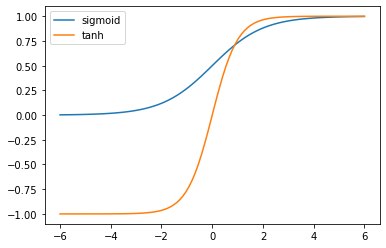

In [12]:
def sigmoid(x):
    return 1./(1 + exp(-x))

xs = linspace(-6, 6, 100)
plot(xs, sigmoid(xs), label='sigmoid')
plot(xs, tanh(xs), label='tanh')

legend(loc=0)

These units are grouped into layers, each having multiple units, and with the outputs of the units of one layer feeding into the units of the next layer.

This is easiest to show graphically, so we define a function to create a network diagram:

In [13]:
def viewnet(layers, weights=None):
    names = ['Input'] + ['Hidden %d' % l for l in range(1,len(layers)-1)] + ['Output']
    labels = ['x'] + ['z'] * (len(layers)-2) + ['y']
    gr = pydot.Dot(graph_type='graph', rankdir='LR', splines='line', fontname='sans-serif', nodesep=0.5, ranksep=2)
    weights = np.array(weights) if weights is not None else None

    layernodes = []
    
    def wbox(s):
        return '''<<TABLE BGCOLOR="white" BORDER="0" CELLBORDER="0" CELLSPACING="0">
                  <TR><TD><FONT COLOR="red" POINT-SIZE="10">%s</FONT></TD></TR></TABLE>>''' % s

    # Create our layers
    for l, height in enumerate(layers):
        layer = pydot.Cluster(graph_name='Layer%d' % l, label=names[l], margin='20')
        
        # HSV colour, split the hue among layers
        layer.set_bgcolor('%f,.4,1' % (float(l)/len(layers)))
        
        nodenames = []
        
        # Create our units
        for k in range(height):
            name = '%d %s' % (k+1, names[l])
            label = labels[l] + str(k+1)
            tooltip = ''
            xlabel = ''
            if l > 0 and weights is not None:
                # Show bias on hover
                tooltip = 'bias=%+d' % weights[l-1][k,0]
                xlabel = wbox('bias %+d' % (weights[l-1][k,0]))
                
            node = pydot.Node(name, label=label, regular=True, fontname='sans-serif',
                              tooltip=tooltip, xlabel=xlabel)
            layer.add_node(node)
            nodenames.append(name)
            
        layernodes.append(nodenames)
        gr.add_subgraph(layer)
    
        if l > 0:
            # Add edges between previous and this layer
            for i1, n1 in enumerate(layernodes[l-1]):
                for i2, n2 in enumerate(layernodes[l]):
                    # hack to keep the node orders sequential
                    # only 'constrain' the edge between middle nodes
                    constrain = i1 == floor(len(layernodes[l-1])/2.) and i2 == floor(height/2.)
                    tooltip = 'w%d%d' % (i2+1,i1+1)
                    wt = ''
                    if weights is not None:
                        tooltip += '=%d' % weights[l-1][i2,i1+1] # +1 for bias
                        wt = '     %d     ' % weights[l-1][i2,i1+1]
                    gr.add_edge(pydot.Edge(n1, n2, tooltip=tooltip, dir='forward',
                                           constraint=constrain, xlabel=wt))
    # remove superfluous tooltips
    svg = re.sub('<title>.*</title>', '', gr.create_svg().decode("utf-8") )
    return SVG(svg)

Now we show a layer with 4 of these sigmoid units, along with an "input" layer that represents a 2D sample point. (Not showing the biases).

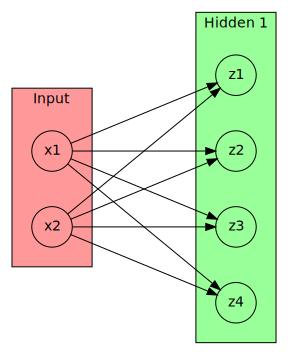

In [14]:
# Create a diagram with 2 input units and 4 hidden units
# (ignoring output units now by setting to 0)
viewnet(layers=[2,4,0])

This can be represented by:

\begin{equation}
z_j = \sigma(a_j) = \sigma(\sum_{i=1}^{D}w_{ji}x_i + w_{j0})
\end{equation}

Where $a_j$ is our "activation" which is transformed by the nonlinear "activation function" $\sigma$

Or, if we define $x_0$ to be constant 1, we can write it in vector form as:

\begin{equation}
\mathbf{z} = \sigma(W \mathbf{x})
\end{equation}

(the sigmoid being element-wise)

For example, with the appropriate weights and biases we can represent various boolean functions. Here an output > 0.5 is true and < 0.5 is false.

In [15]:
biases = [-3, -1, 3, 1]

weights = [[ 2.,  2.], # AND
           [ 2.,  2.], # OR
           [-2., -2.], # NAND
           [-2., -2.]] # NOR

# concatenate the biases and weights into one array
W = zeros((4,3))
W[:,0], W[:,1:] = biases, weights

print('W = \n', W, '\n')

# test with x1=0, x2=1
x = [0, 1]

# set x0 to be constant 1
x = [1] + x

print('x = ', x, '\n')

print('activation:', dot(W, x))
print('nonlinear transform:', sigmoid(dot(W, x)))

W = 
 [[-3.  2.  2.]
 [-1.  2.  2.]
 [ 3. -2. -2.]
 [ 1. -2. -2.]] 

x =  [1, 0, 1] 

activation: [-1.  1.  1. -1.]
nonlinear transform: [0.26894142 0.73105858 0.73105858 0.26894142]


We make a couple of functions to compute a sigmoid and tanh layer

In [16]:
def sigmoid_layer(x, W):
    assert x[0] == 1
    return sigmoid(dot(W, x))

def tanh_layer(x, W):
    assert x[0] == 1
    return tanh(dot(W, x))

Using our boolean weights with a tanh unit, we get a positive value for true and a negative value for false.

In [17]:
print('x1  x2    AND         OR          NAND        NOR')
for x1 in (0,1):
    for x2 in (0,1):
        print(x1, ' ', x2, ' ', tanh_layer([1, x1, x2], W))

x1  x2    AND         OR          NAND        NOR
0   0   [-0.99505475 -0.76159416  0.99505475  0.76159416]
0   1   [-0.76159416  0.76159416  0.76159416 -0.76159416]
1   0   [-0.76159416  0.76159416  0.76159416 -0.76159416]
1   1   [ 0.76159416  0.99505475 -0.76159416 -0.99505475]


So far so good, but this is all stuff we could do with a Perceptron (a simple threshold unit, ie $\operatorname{sign}(\mathbf{w}.\mathbf{x})$). Why do we need the sigmoidal function?

Well, with a single non-linear layer (sigmoidal or perceptron) there are functions we cannot represent, for example no configuration of the weights above would allow us to compute boolean XOR. However, with additional layers the story is different. Indeed, some combination of NAND units is sufficient to compute any boolean function. In fact any boolean function can be computed with just two layers, using a combination of OR and AND units, since any boolean function can be expressed in disjunctive normal form (an OR of ANDs of inputs and their negations, where negation can be expressed by the weights).

This gives us greater representational power, but still could be done by multiple layers of perceptron units. The difference is when it comes to learning the weights from samples. There is no efficient learning rule for multiple layers of perceptron units, but because the sigmoid units are smooth we can find their gradient, which gives rise to an efficient learning algorithm called Backpropagation.

In [18]:
# Implement XOR, by setting weights such that
# the AND and OR columns above are added, then -1
#
#                bias AND  OR   NAND NOR
W_out = array([[-1.0, 0.0, 1.0, 1.0, 0.0]])

print('x1  x2  XOR')
        
for x1 in (0,1):
    for x2 in (0,1):
        print(x1, ' ', x2, ' ', tanh_layer([1]+list(tanh_layer([1, x1, x2], W)), W_out))

x1  x2  XOR
0   0   [-0.64491267]
0   1   [0.48015701]
1   0   [0.48015701]
1   1   [-0.64491267]


A diagram of our "handmade" XOR net.

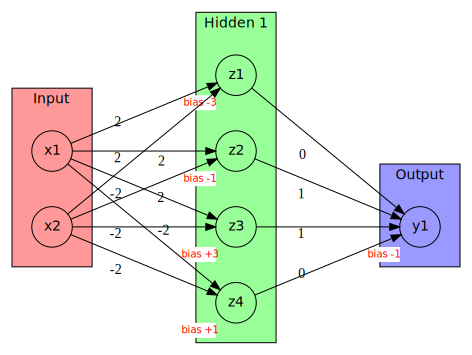

In [19]:
viewnet(layers=[2,4,1], weights=[W, W_out])

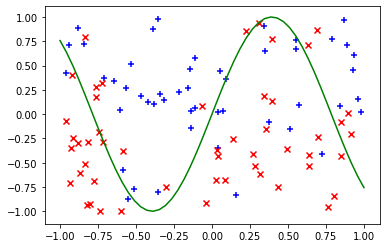

In [20]:
#TODO...maybe try an example like this

xs = 2 * random.random(100) - 1
ys = 2 * random.random(100) - 1

training = array([xs, ys]).T
targets = ys > sin(4 * xs) + randn(100)

plot(linspace(-1,1),sin(4 * linspace(-1,1)), 'g')


#scatter(xs, ys, c=targets)
scatter(xs[targets], ys[targets], c='b', marker='+')
scatter(xs[~targets], ys[~targets], c='r', marker='x')